In [1]:
try:
    from google.colab import files
    # We are in colab
    !rm -r 3d-style/
    !git clone https://github.com/leoHeidel/stylegan2-keras.git
    !cp -r 3d-style/* ./

except ImportError:
    # We are not in colab 
    pass

rm: cannot remove '3d-style/': No such file or directory
Cloning into '3d-style'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 59), reused 85 (delta 27), pack-reused 0
Receiving objects: 100% (121/121), 857.79 KiB | 6.65 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('cifar10', split='train', shuffle_files=True)


#To use another dataset:
#!wget http://address_to_dataset/dataset.zip
#!unzip -q dataset.zip

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7KST1G/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7KST1G/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


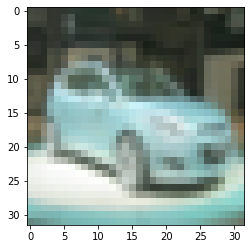

In [14]:
"""
As a eample we will generate more images from one class of the cifar-10 dataset.
Obviously, since the image quality of this dataset is low, 
this in not exceptional.
However this can run quickly enough on colab. 
"""

label = 1
def img_generator():
  for x in ds:
    if x['label'] == label:
      yield tf.cast(x['image'], tf.float32)[...,:3] / 255

im_dataset = tf.data.Dataset.from_generator(img_generator, tf.float32)

#Taking an example:
for im in im_dataset.take(1):
  pass
plt.imshow(im)

for im in im_dataset.take(1):
  pass
plt.imshow(im)

In [15]:
"""
This is the noise we use to generate test examples.
"""
def noise_image(batch_size):
  random_u = np.random.uniform(size = [batch_size, im_size, im_size, 1])
  return random_u.astype('float32')
def latent_z(n):
  return np.random.normal(size=[n, latent_size]).astype('float32')

In [16]:
"""
Building of the stylke gan model, the parameters are very low, 
to ensure this runs in colab.
"""

import style_gan_3d

im_size = 32
batch_size = 64 
latent_size = 256
channels = 32
#Chosing the number of layer this way, means we start with 4x4
n_layers = int(np.log2(im_size) - 1) 

model = style_gan_3d.style_gan.StyleGan(im_size=im_size, 
                                        latent_size=latent_size, 
                                        channels=channels)
model.compile(run_eagerly=True)

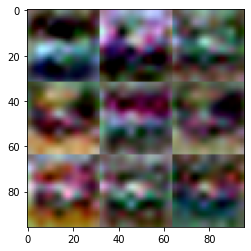

1562/1562 [==============================] - 426s 273ms/step - disc_loss: 1.8665 - gen_loss: 0.3285 - divergence: 1.5151 - pl_lengths: 0.1629


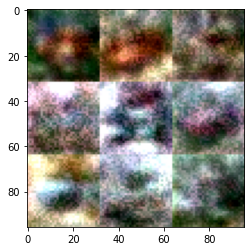

1562/1562 [==============================] - 428s 274ms/step - disc_loss: 1.9198 - gen_loss: 0.1676 - divergence: 1.7354 - pl_lengths: 0.1945


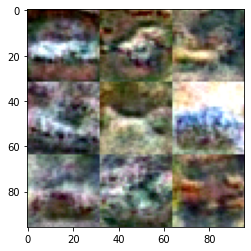

1562/1562 [==============================] - 427s 273ms/step - disc_loss: 1.9506 - gen_loss: 0.1351 - divergence: 1.8206 - pl_lengths: 0.2015


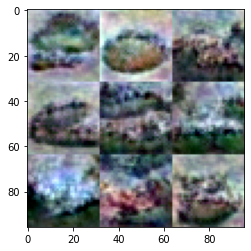

1562/1562 [==============================] - 425s 272ms/step - disc_loss: 1.9621 - gen_loss: 0.1197 - divergence: 1.8693 - pl_lengths: 0.1994


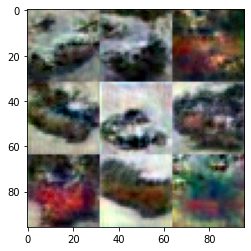

1562/1562 [==============================] - 425s 272ms/step - disc_loss: 1.9664 - gen_loss: 0.1158 - divergence: 1.8939 - pl_lengths: 0.1968


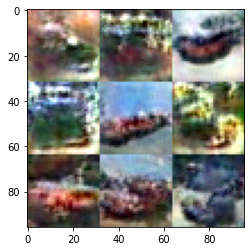

1562/1562 [==============================] - 422s 270ms/step - disc_loss: 1.9595 - gen_loss: 0.0620 - divergence: 1.8981 - pl_lengths: 0.1872


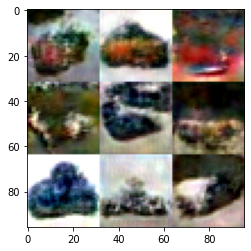

1562/1562 [==============================] - 426s 273ms/step - disc_loss: 1.9324 - gen_loss: 0.0992 - divergence: 1.8576 - pl_lengths: 0.1820


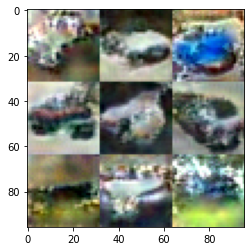

1562/1562 [==============================] - 422s 270ms/step - disc_loss: 1.9357 - gen_loss: 0.0921 - divergence: 1.8611 - pl_lengths: 0.1802


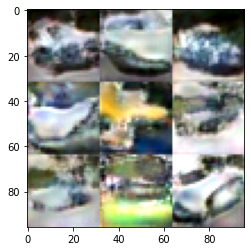

1562/1562 [==============================] - 426s 273ms/step - disc_loss: 1.9399 - gen_loss: 0.0655 - divergence: 1.8708 - pl_lengths: 0.1803


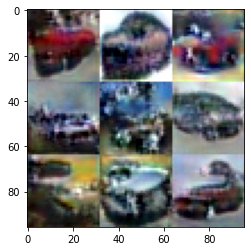

1562/1562 [==============================] - 425s 272ms/step - disc_loss: 1.9408 - gen_loss: 0.0740 - divergence: 1.8748 - pl_lengths: 0.1789


In [18]:
#This create a corresponding infinite tensorlfow dataset.
dataset = style_gan_3d.dataset.train_dataset_with_tf_dataset(im_dataset, 
                                                             n_layers=n_layers, 
                                                             im_size=im_size, 
                                                             batch_size=im_size,
                                                             latent_size=latent_size)
#If using own's dataset: 
#dataset = style_gan_3d.dataset.train_dataset(path, n_layers=n_layers, 
#                                                             im_size=im_size, 
#                                                             batch_size=im_size,
#                                                             latent_size=latent_size)

for i in range(10):
  #Generating 9 test examples
  noise = noise_image(9)
  l_z = latent_z(9)
  #model.M map the lattent vector z to w (Notation from the article).
  l_w = model.M(l_z)
  style = tf.stack([l_w for i in range(model.n_layers)],axis=1)
  #The seed is what the generator start with, in this case, a learnt constant
  seed = model.S(style)
  #From the seed, the style w and the noise, model.G generate an image.
  generated = model.G([seed, style,noise])
  #paking them together
  img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) 
                                  for i in range(3)], axis=0)
  plt.imshow(img)
  plt.show()

  #We manually define the number of steps per epoch as the training dataset is
  #an infinite loop.
  steps_per_epoch = 100000//batch_size
  model.fit(dataset.take(steps_per_epoch), steps_per_epoch=steps_per_epoch)
  model.save_weights("model.tf")

In [23]:
def evaluate(M,S,G):
  #Generating 9 test examples
  noise = noise_image(9)
  l_z = latent_z(9)
  #model.M map the lattent vector z to w (Notation from the article).
  l_w = M(l_z)
  style = tf.stack([l_w for i in range(model.n_layers)],axis=1)
  #The seed is what the generator start with, in this case, a learnt constant
  seed = S(style)
  #From the seed, the style w and the noise, model.G generate an image.
  generated = G([seed, style,noise])
  #paking them together
  img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) 
                                  for i in range(3)], axis=0)
  return img.numpy()

In [22]:
import tqdm.notebook as tqdm
"""
In order to improve the quality of the gereated images, 
we can take an exponential moving average of the model during training
"""

ema_steps = 1000
model.init_ema()
for example in tqdm.tqdm(dataset.take(ema_steps), total=ema_steps):
  model.train_step(example)
  model.ema_step()

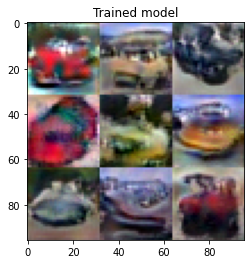

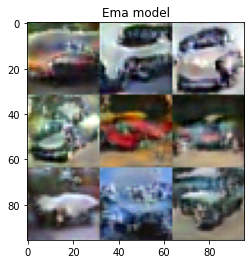

In [24]:
plt.imshow(evaluate(model.M,model.S,model.G))
plt.title("Trained model")
plt.show()

plt.imshow(evaluate(model.ema_M,model.ema_S,model.ema_G))
plt.title("Ema model")
plt.show()

For better training, the model needs to be tained much longer